In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import string

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from RainySeason import *
from utils import *

mpl_settings() #custom function for nicer plots

In [2]:
### load data

# RS metric parameters
pS = pd.read_csv(r'./params/RSO_params_afterOptim.csv',index_col=0)
pE = pd.read_csv(r'./params/RSE_params_afterOptim.csv',index_col=0)

# remove init and AWS
pS = pS.loc[:,~pS.columns.str.contains('init')]
pS = pS.loc[:,~pS.columns.str.contains('AWS')]
pE = pE.loc[:,~pE.columns.str.contains('init')]
pE = pE.loc[:,~pE.columns.str.contains('AWS')]

# LSP data
lsp = pd.read_csv('.\inputs\LSP_targets.csv',index_col=0,parse_dates=True)
SOS_w = lsp['SOS_no_lag'] - lsp['lag_WRF']
SOS_c = lsp['SOS_no_lag'] - lsp['lag_CHIRPS']
SOS_a = lsp['SOS_no_lag'] - lsp['lag_AWS']
SOS_b = lsp['SOS_no_lag'] 

EOS_w = lsp['EOS_no_lag'] - lsp['lag_WRF']
EOS_c = lsp['EOS_no_lag'] - lsp['lag_CHIRPS']
EOS_a = lsp['EOS_no_lag'] - lsp['lag_AWS']
EOS_b = lsp['EOS_no_lag'] 

# rainy season metrics past
sdf_w = pd.read_csv('./outputs/RSO_WRF_past.csv',index_col=0)
sdf_c = pd.read_csv('./outputs/RSO_CHI_past.csv',index_col=0)

edf_w = pd.read_csv('./outputs/RSE_WRF_past.csv',index_col=0)
edf_c = pd.read_csv('./outputs/RSE_CHI_past.csv',index_col=0)

# rainy season metrics future
sdf_f = pd.read_csv('./outputs/RSO_metrics_CMIP_future.csv',index_col=0)

s_rcp85_avg = sdf_f.loc[:,sdf_f.columns.str.contains('avg_85')]
s_rcp85_std = sdf_f.loc[:,sdf_f.columns.str.contains('std_85')]
s_rcp45_avg = sdf_f.loc[:,sdf_f.columns.str.contains('avg_45')]
s_rcp45_std = sdf_f.loc[:,sdf_f.columns.str.contains('std_45')]

edf_f = pd.read_csv('./outputs/RSE_metrics_CMIP_future.csv',index_col=0)

e_rcp85_avg = edf_f.loc[:,edf_f.columns.str.contains('avg_85')]
e_rcp85_std = edf_f.loc[:,edf_f.columns.str.contains('std_85')]
e_rcp45_avg = edf_f.loc[:,edf_f.columns.str.contains('avg_45')]
e_rcp45_std = edf_f.loc[:,edf_f.columns.str.contains('std_45')]

# Fig 7: Trends RSO

In [3]:
### plot preparation
c1,c2 = '#1b9e77','#d95f02'

backgrounds = ['#785EF0','#FFB000','#DC267F']
alpha = int(0.1 * 255)  
alpha_hex = format(alpha, '02x') 
sig_lim = .05

# x_axes extents
x_p = np.arange(1981,2018)
x_c = np.arange(2000,2018)
x_f = np.arange(2019,2100)

rso_metric_names = ['Gurgiser', 'Climandes', 'Garcia','FP','JD', 'Bucket', 'LM', 'CB']
rse_metric_names = ['Gurgiser', 'Climandes', 'Garcia', 'Bucket', 'LM', 'CB']

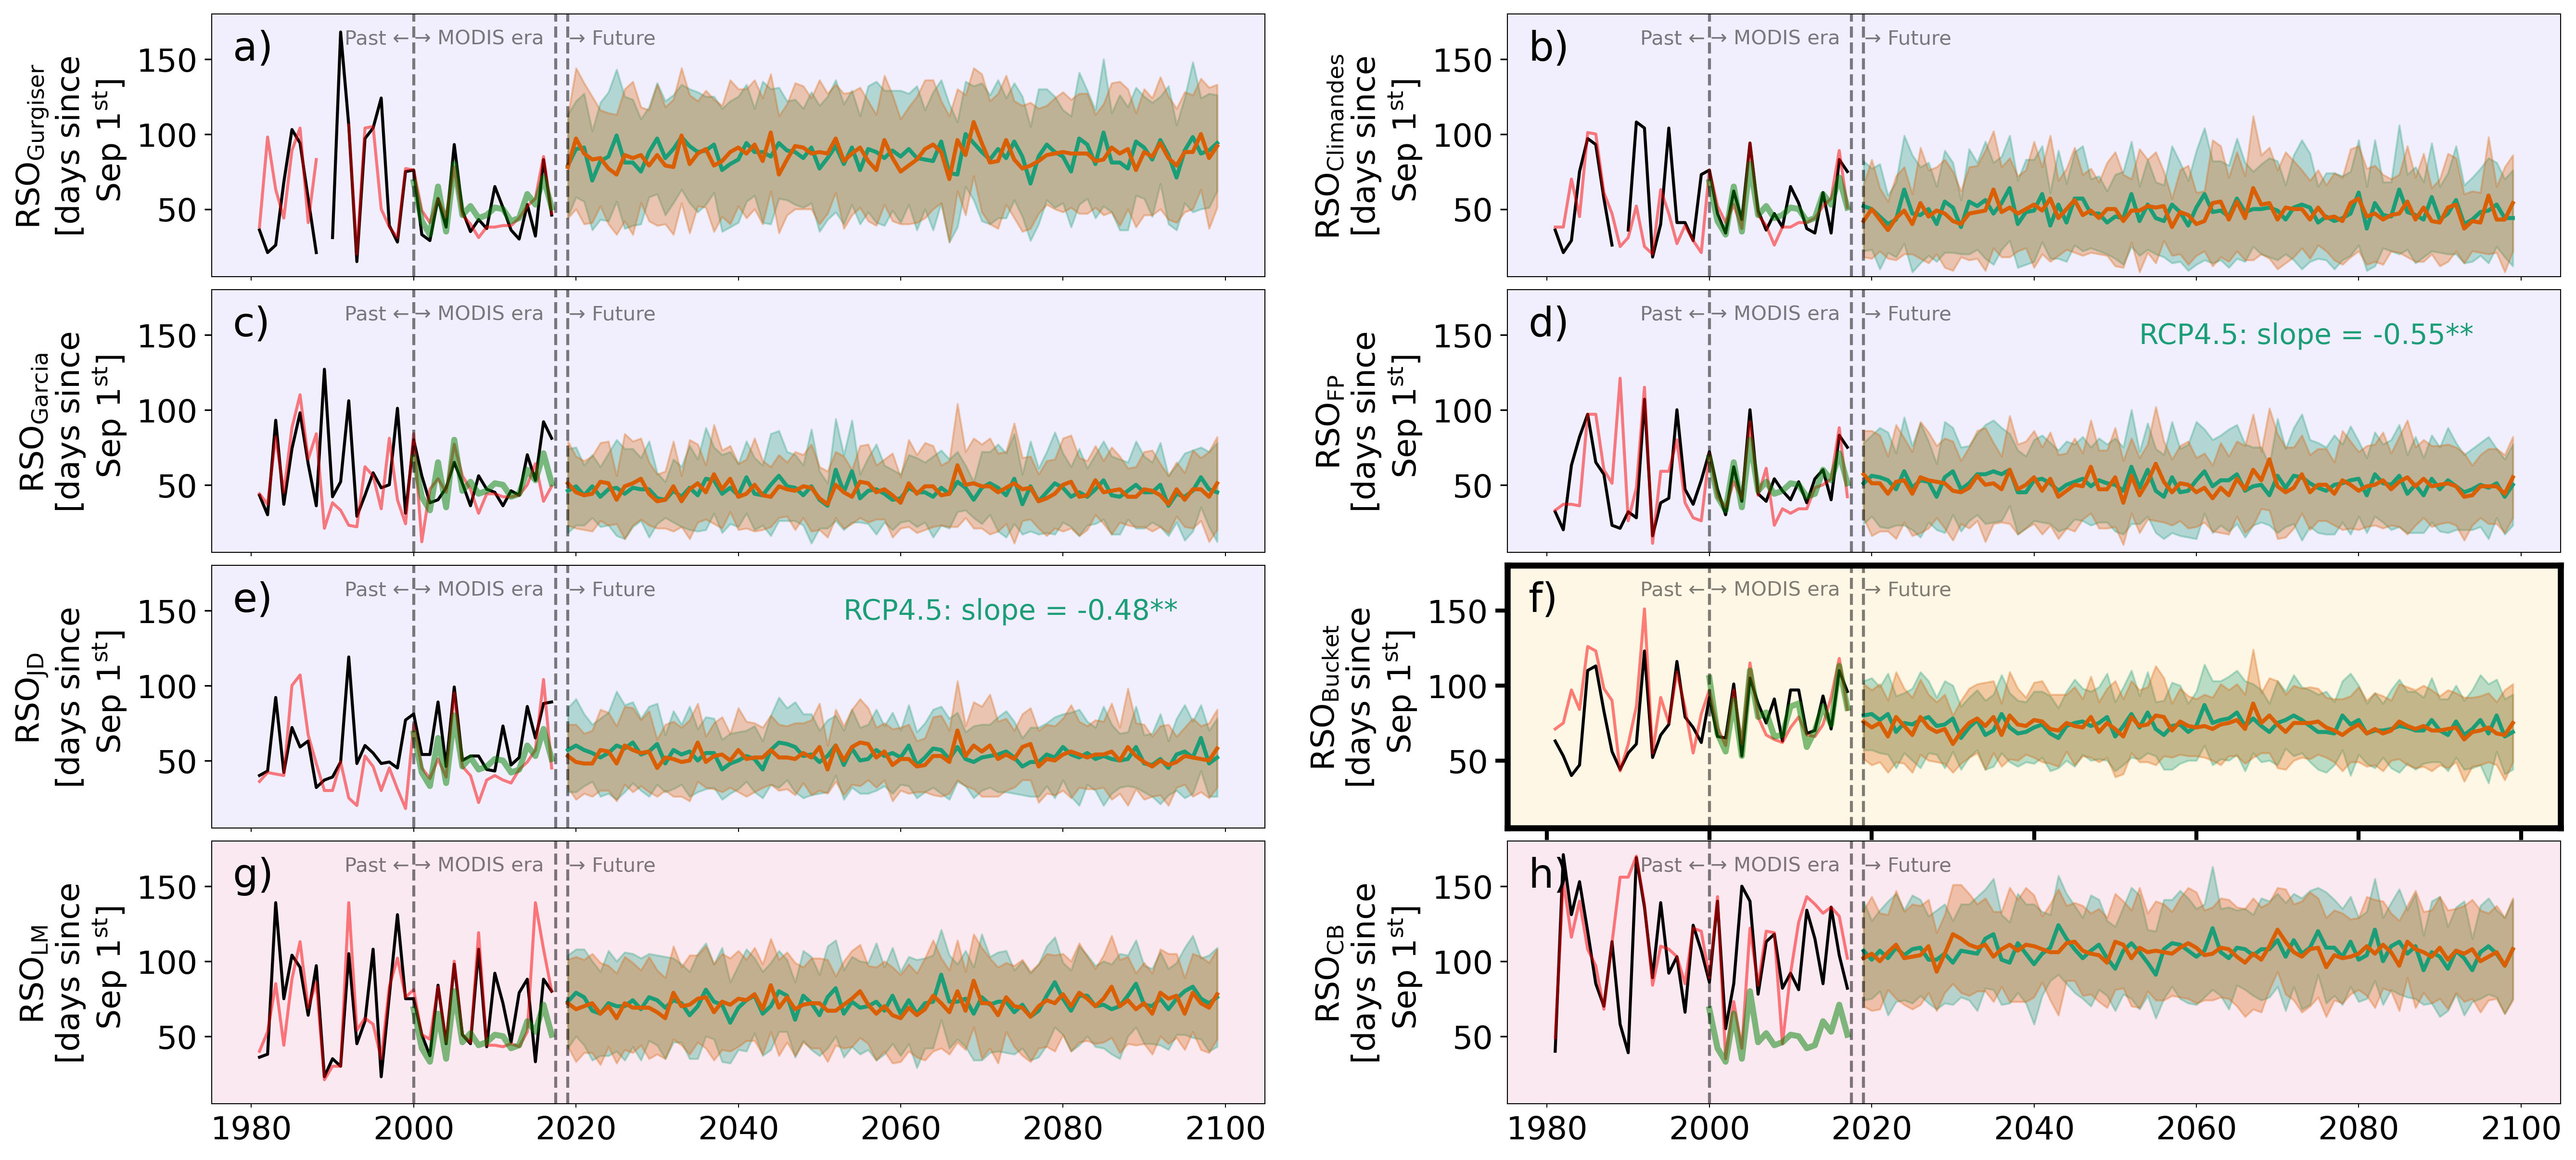

In [4]:
### plot it
fig, axs = plt.subplots(4,2,figsize=(21,10),dpi=300,sharex=True,sharey=False)
axs = axs.ravel()

for i,ax in enumerate(axs):
    
    ################################ PAST ################################
    wrf_p = sdf_w.iloc[:,i]
    chi_p = sdf_c.iloc[:,i]
    wrf_p = wrf_p.where(~(wrf_p < 0))
    chi_p = chi_p.where(~(chi_p < 0))

    ax.plot(x_p,wrf_p,c='k')
    ax.plot(x_p,chi_p,c='r',alpha=.5)
    
    w_p_lab = sig_trend(wrf_p.index,wrf_p,sig_lim=sig_lim)
    c_p_lab = sig_trend(chi_p.index,chi_p,sig_lim=sig_lim)

    trend_label_past(w_p_lab,ax)
    trend_label_past(c_p_lab,ax,pos='low')

    ################################ NDVI ################################
    if ax == axs[-3]:
        ax.plot(x_c,SOS_b,'g',linewidth=3,alpha=.5)
    else:        
        ax.plot(x_c,SOS_w,'g',linewidth=3,alpha=.5)    
        
    ################################ FUTURE ################################    
    # RCP 4.5
    avg,std = s_rcp45_avg.iloc[:,i],s_rcp45_std.iloc[:,i]
    
    ax.plot(x_f,avg,c1,linewidth=2,label='ensemble')
    ax.fill_between(x_f, avg-std, avg+std,color=c1,alpha=.3)
    
    label = sig_trend(x_f,avg,sig_lim=sig_lim)
    trend_label_futu(label,ax,scen='45',c1=c1,c2=c2)
    
    # RCP 8.5
    avg,std = s_rcp85_avg.iloc[:,i],s_rcp85_std.iloc[:,i]
    
    ax.plot(x_f,avg,c2,linewidth=2,label='ensemble')
    ax.fill_between(x_f, avg-std, avg+std,color=c2,alpha=.3)

    label = sig_trend(x_f,avg,sig_lim=sig_lim)
    trend_label_futu(label,ax,scen='85',c1=c1,c2=c2)
    
    
    ################################ Background ################################
    if i < 5:   
        ax.set_facecolor(backgrounds[0] + alpha_hex)
    elif i == 5:   
        ax.set_facecolor(backgrounds[1] + alpha_hex)
        for spine in ax.spines.values():
            spine.set_linewidth(3) 
        ax.tick_params(axis='both', which='major', length=6, width=2, direction='out')

    else:   
        ax.set_facecolor(backgrounds[2] + alpha_hex)

    set_plot_params(ax=ax,label_size=16, tick_size=16, text_size=14)
    
    ################################ STYLE ################################
    ax.set_ylabel('$RSO_{' + rso_metric_names[:][i] + '}$ \n [days since \n Sep $1^{st}$]')
    ax.set_ylim(5,180)
    ax.axvline(2000,c='k',linestyle='--',alpha=.5)
    ax.axvline(2017.5,c='k',linestyle='--',alpha=.5)
    ax.text(2000.1,160,'→ MODIS era',alpha=.5,rotation=0)
    ax.text(1991.5,160,'Past ←',alpha=.5,rotation=0)

    ax.axvline(2019,c='k',linestyle='--',alpha=.5)
    ax.text(2019.1,160,'→ Future',alpha=.5,rotation=0)
    ax.text(0.02,0.825,string.ascii_lowercase[i]+')',fontsize=20,transform = ax.transAxes)

fig.subplots_adjust(wspace=.23,hspace=0.05)
plt.savefig('./figures/Fig06.pdf',bbox_inches='tight')

# Fig 8: Trends RSE

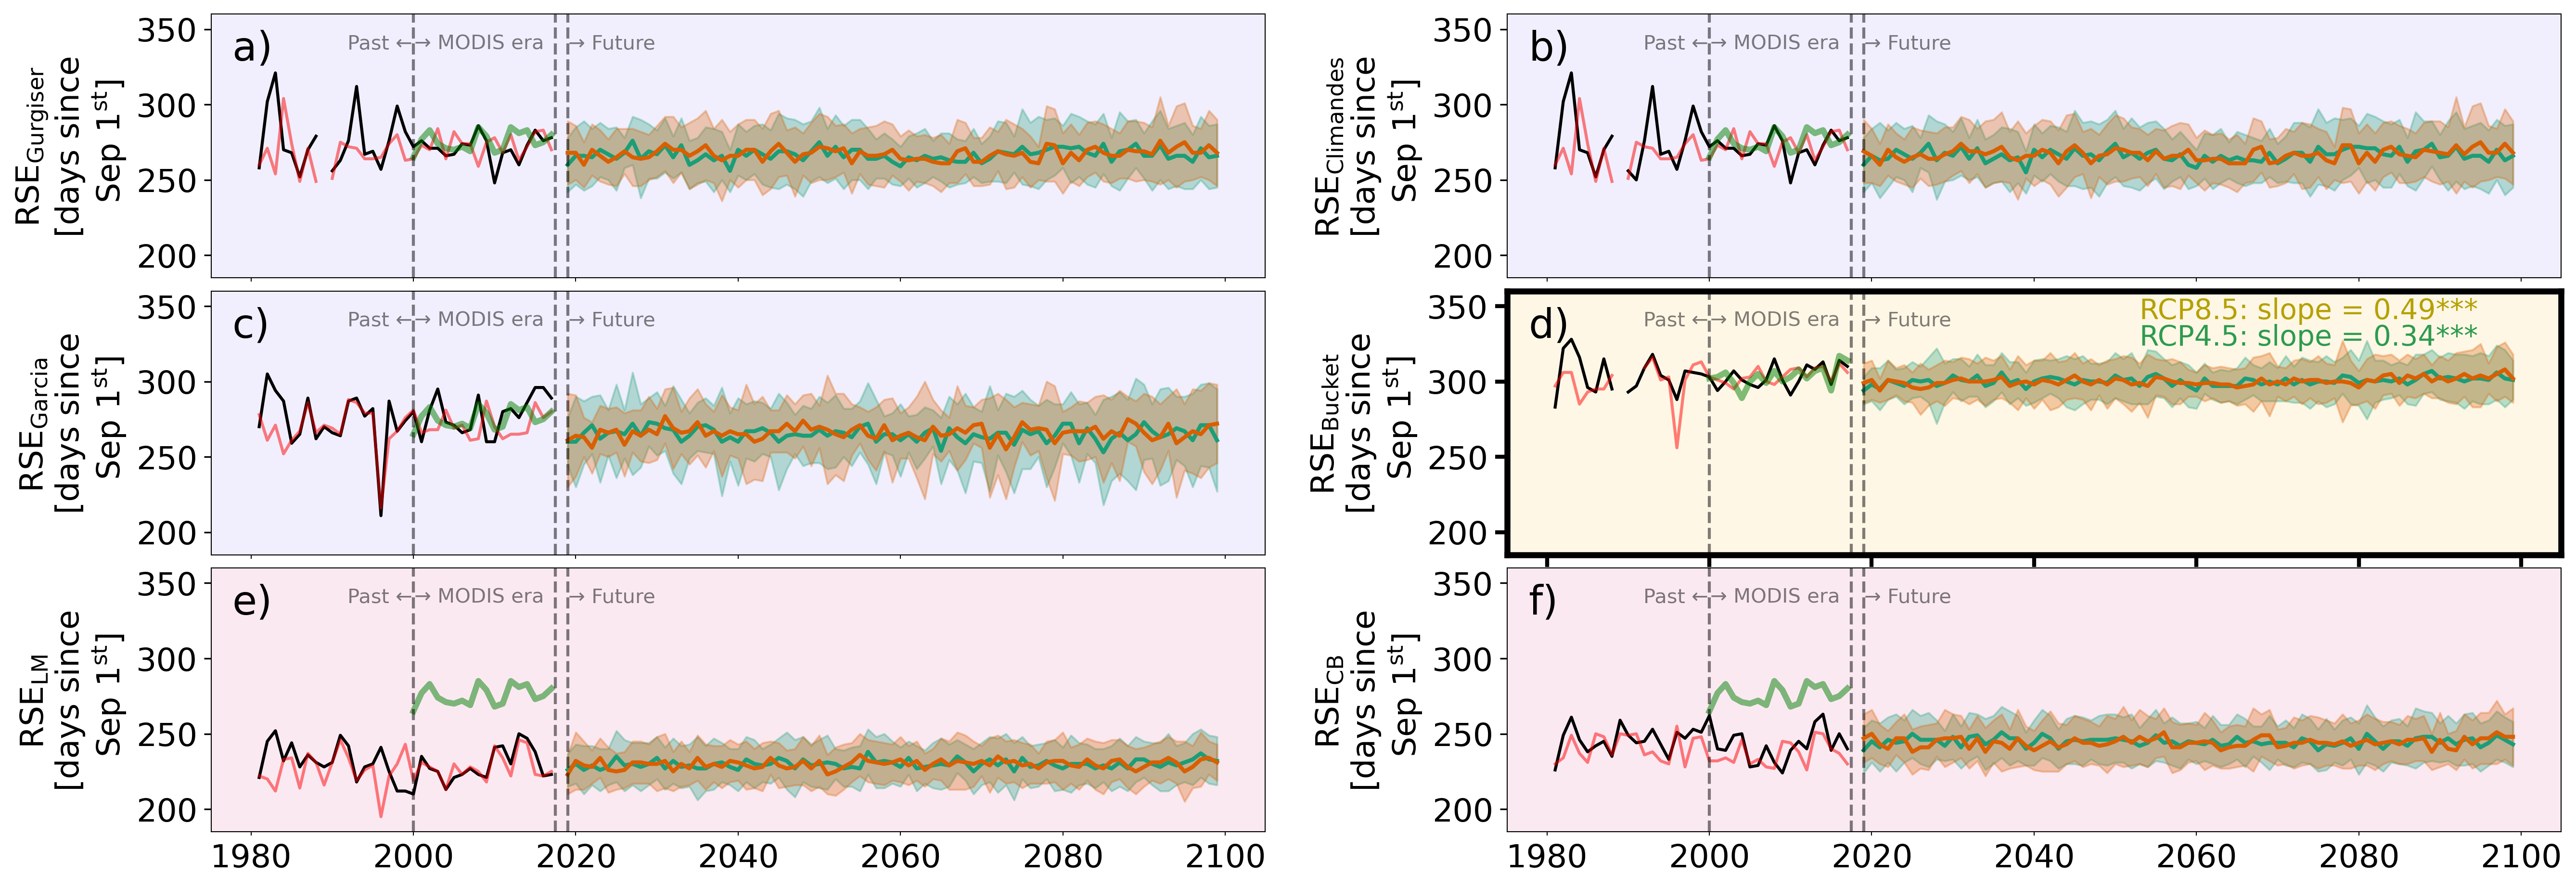

In [5]:
### plot it
fig, axs = plt.subplots(3,2,figsize=(21,7.5),dpi=300,sharex=True,sharey=False)
axs = axs.ravel()

for i,ax in enumerate(axs[:]):
    ax.set_ylim(185, 360)
    ################################ PAST ################################
    wrf_p = edf_w.iloc[:,i]
    wrf_p = wrf_p.where(~(wrf_p < 150))
    chi_p = edf_c.iloc[:,i]
    chi_p = chi_p.where(~(chi_p < 150))

    ax.plot(x_p,wrf_p,c='k')
    ax.plot(x_p,chi_p,c='r',alpha=.5)

    w_p_lab = sig_trend(wrf_p.index,wrf_p,sig_lim=sig_lim)
    c_p_lab = sig_trend(chi_p.index,chi_p,sig_lim=sig_lim)

    trend_label_past(w_p_lab,ax)
    trend_label_past(c_p_lab,ax,pos='low')

    ################################ NDVI ################################
    if ax == axs[-3]:
        ax.plot(x_c,EOS_b,'g',linewidth=3,alpha=.5)
    else:        
        ax.plot(x_c,EOS_w,'g',linewidth=3,alpha=.5)
        
    ################################ FUTURE ################################    
    # RCP 4.5
    avg,std = e_rcp45_avg.iloc[:,i],e_rcp45_std.iloc[:,i]
    ax.plot(x_f,avg,c1,linewidth=2,label='ensemble')
    ax.fill_between(x_f, avg-std, avg+std,color=c1,alpha=.3)
    
    label = sig_trend(x_f,avg,sig_lim=sig_lim)
    trend_label_futu(label,ax,scen='45')
    
    # RCP 8.5
    avg,std = e_rcp85_avg.iloc[:,i],e_rcp85_std.iloc[:,i]    
    ax.plot(x_f,avg,c2,linewidth=2,label='ensemble')
    ax.fill_between(x_f, avg-std, avg+std,color=c2,alpha=.3)

    label = sig_trend(x_f,avg,sig_lim=sig_lim)
    trend_label_futu(label,ax,scen='85') 
    
    ################################ STYLE ################################
    ax.set_ylabel('$RSE_{' + rse_metric_names[:][i] + '}$ \n [days since \n Sep $1^{st}$]')
    set_plot_params(ax=ax,label_size=16, tick_size=16, text_size=14)

    ax.axvline(2000,c='k',linestyle='--',alpha=.5)
    ax.axvline(2017.5,c='k',linestyle='--',alpha=.5)
    ax.text(2000.1,337,'→ MODIS era',alpha=.5,rotation=0)
    ax.text(1991.9,337,'Past ←',alpha=.5,rotation=0)

    ax.axvline(2019,c='k',linestyle='--',alpha=.5)
    ax.text(2019.1,337,'→ Future',alpha=.5,rotation=0)
    ################################ Background ################################
    if i < 3:   
        ax.set_facecolor(backgrounds[0] + alpha_hex)
    elif i == 3:   
        ax.set_facecolor(backgrounds[1] + alpha_hex)
        for spine in ax.spines.values():
            spine.set_linewidth(3) 
        ax.tick_params(axis='both', which='major', length=6, width=2, direction='out')

    else:   
        ax.set_facecolor(backgrounds[2] + alpha_hex)
   
    
    ax.text(0.02,0.825,string.ascii_lowercase[i]+')',fontsize=20,transform = ax.transAxes)

fig.subplots_adjust(wspace=.23,hspace=0.05)    
plt.savefig('./figures/Fig07.pdf',bbox_inches='tight')

# Some numbers, partly mentioned in the paper

In [6]:
print('std until 2000',np.round(sdf_w[sdf_w > 0].iloc[0:19,:].std().mean(),2))
print('std from 2000',np.round(sdf_w[sdf_w > 0].iloc[19:,:].std().mean(),2))

print('cv until 2000',np.round(((sdf_w[sdf_w > 0].iloc[0:19,:].std() / sdf_w[sdf_w > 0].iloc[0:19,:].mean()) * 100).mean(),1))
print('cv from 2000',np.round(((sdf_w[sdf_w > 0].iloc[19:,:].std() / sdf_w[sdf_w > 0].iloc[19:,:].mean()) * 100).mean(),1))

iqr_bef = sdf_w[sdf_w > 0].iloc[0:19,:].mean(axis=1).describe()['75%'] - sdf_w[sdf_w > 0].iloc[0:19,:].mean(axis=1).describe()['25%']
iqr_aft = sdf_w[sdf_w > 0].iloc[19:,:].mean(axis=1).describe()['75%'] - sdf_w[sdf_w > 0].iloc[19:,:].mean(axis=1).describe()['25%']


print('IQR until 2000',np.round(iqr_bef,2))
print('IQR from 2000',np.round(iqr_aft,2))


std until 2000 32.2
std from 2000 19.93
cv until 2000 48.6
cv from 2000 31.0
IQR until 2000 26.98
IQR from 2000 16.44


# Figs. S7, S8

<ipython-input-7-1dc112622721>:17: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_percentage = df.div(df.sum(level=0), level=0) * 100


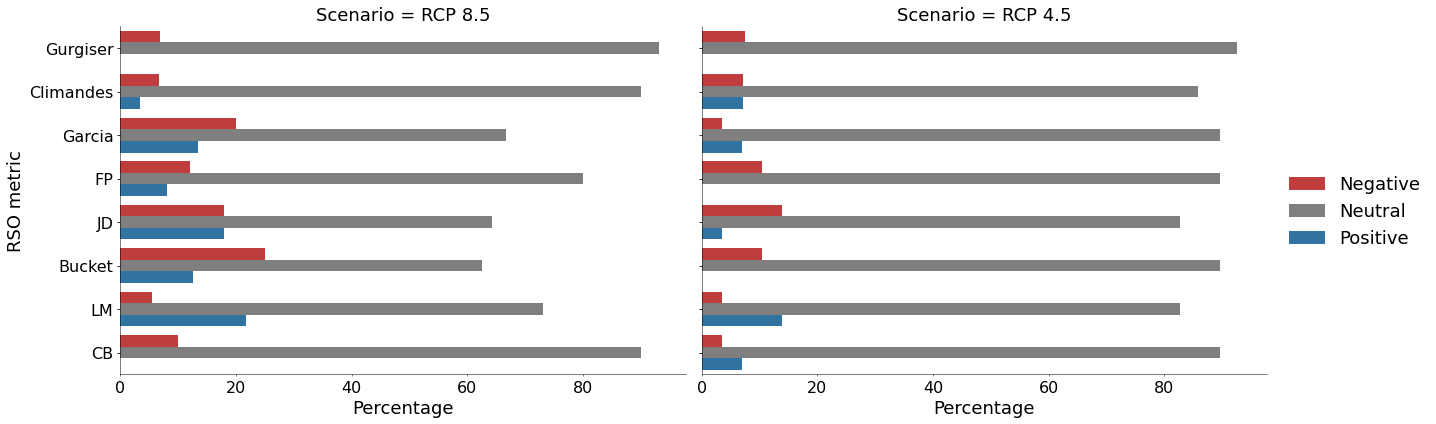

In [7]:
### Fig S7

RSO = np.array([
    [0, 1, 4, 2, 5, 4, 8, 0],  # RSO_pos_85
    [2, 2, 6, 3, 5, 8, 2, 3],  # RSO_neg_85
    [27,27,20,20,18,20,27,27],  # RSO_neutral_85
    [0, 2, 2, 0, 1, 0, 4, 2],  # RSO_pos_45
    [2, 2, 1, 3, 4, 3, 1, 1],  # RSO_neg_45
    [25,24,26,26,24,26,24,26]])   # RSO_neutral_45


time_periods = ['Gurgiser','Climandes', 'Garcia', 'FP', 'JD', 'Bucket', 'LM', 'CB']
index = pd.MultiIndex.from_product([['RCP 8.5', 'RCP 4.5'], ['Positive', 'Negative', 'Neutral']],
    names=['Scenario', 'Trend'])

df = pd.DataFrame(RSO, index=index, columns=time_periods)
df_percentage = df.div(df.sum(level=0), level=0) * 100
df_percentage = df_percentage.T
df = df.T
df_melted = df_percentage.reset_index().melt(id_vars='index', var_name=['Scenario', 'Trend'], value_name='Percentage')

df_melted.rename(columns={'index': 'Time Period'}, inplace=True)
df_counts = df.reset_index().melt(id_vars='index', var_name=['Scenario', 'Trend'], value_name='Count')
df_counts.rename(columns={'index': 'Time Period'}, inplace=True)

colors = ['#d62728', '#7f7f7f', '#1f77b4']  # Red, Gray, Blue
trend_order = ['Negative', 'Neutral', 'Positive']


g = sns.FacetGrid(df_melted, col='Scenario', col_wrap=2, sharey=True, height=6, aspect=1.5)
g.map_dataframe(sns.barplot, x='Percentage', y='Time Period', hue='Trend', palette=colors, hue_order=trend_order)

for ax in g.axes.flatten():
    ax.tick_params(labelsize=16)  
g.set_titles(size=18)  
g.set_axis_labels('Percentage', 'RSO metric', fontsize=18)
g.add_legend(fontsize=18)
g.tight_layout()

plt.savefig('./figures/FigS7.pdf',bbox_inches='tight')

<ipython-input-8-d3fc8c443a8d>:16: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_percentage = df.div(df.sum(level=0), level=0) * 100


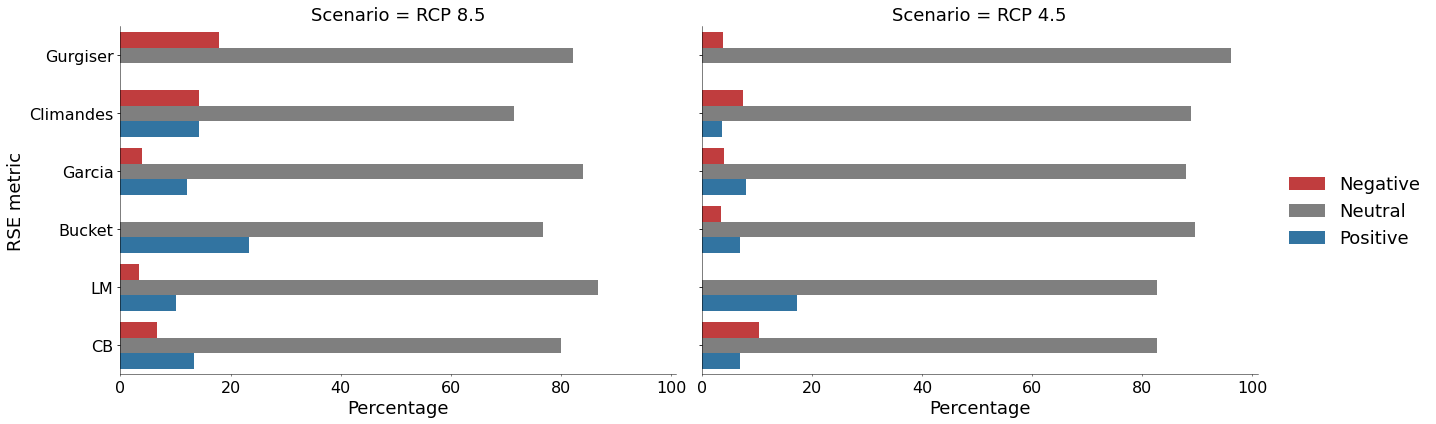

In [8]:
### Fig S8
RSE = np.array([
    [0,4,3,7,3,4],  # RSE_pos_85
    [5,4,1,0,1,2],  # RSE_neg_85
    [23,20,21,23,26,24],  # RSE_neutral_85
    [0,1,2,2,5,2],  # RSE_pos_45
    [1,2,1,1,0,3],  # RSE_neg_45
    [25,24,22,26,24,24]   # RSE_neutral_45
])

time_periods = ['Gurgiser','Climandes', 'Garcia', 'Bucket', 'LM', 'CB']
index = pd.MultiIndex.from_product([['RCP 8.5', 'RCP 4.5'],['Positive', 'Negative', 'Neutral']],
                                   names=['Scenario', 'Trend'])

df = pd.DataFrame(RSE, index=index, columns=time_periods)
df_percentage = df.div(df.sum(level=0), level=0) * 100
df_percentage = df_percentage.T
df = df.T
df_melted = df_percentage.reset_index().melt(id_vars='index', var_name=['Scenario', 'Trend'], value_name='Percentage')

df_melted.rename(columns={'index': 'Time Period'}, inplace=True)
df_counts = df.reset_index().melt(id_vars='index', var_name=['Scenario', 'Trend'], value_name='Count')
df_counts.rename(columns={'index': 'Time Period'}, inplace=True)

colors = ['#d62728', '#7f7f7f', '#1f77b4']  # Red, Grey, Blue
trend_order = ['Negative', 'Neutral', 'Positive']

g = sns.FacetGrid(df_melted, col='Scenario', col_wrap=2, sharey=True, height=6, aspect=1.5)
g.map_dataframe(sns.barplot, x='Percentage', y='Time Period', hue='Trend', palette=colors, hue_order=trend_order)
g.tight_layout()

for ax in g.axes.flatten():
    ax.tick_params(labelsize=16)  
g.set_titles(size=18)  
g.set_axis_labels('Percentage', 'RSE metric', fontsize=18)
g.add_legend(fontsize=18)

g.tight_layout()

plt.savefig('./figures/FigS8.pdf',bbox_inches='tight')